In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path

pl.enable_string_cache()

### functions to draw cue box and assign sex

In [30]:

from coral.config_loader import ConfigLoader
from coral.experimental_metadata import ExperimentMetaData
from coral.data_preprocessor import BehaviorDataPreprocessor, PhotometryDataPreprocessor
config_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/conf/config.yaml'
configs = ConfigLoader(config_path)

In [31]:
def draw_cue_box(ax, color, alpha):
    #  draw box on plot for cue
    y_lower = ax.get_ylim()[0]
    y_ags_sum = sum(np.abs(ax.get_ylim()))
    rect = patches.Rectangle(
        (0, y_lower), width=5, height=y_ags_sum, alpha=alpha, facecolor=color)
    ax.add_patch(rect)
    return rect


### paths to data

In [32]:
behavior_path = Path(
    '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_behavior_data.parquet')
fp_path = Path('/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Mike/LHA_dopamine/LH_NAC_Headfix_FP/Photometry/Pav_Training/claire_cohort/analyzed_data/aggregated_data/aggregated_photometry_data.parquet')
filter_date = datetime.date(2024, 2, 9)

In [33]:
bh_df = pl.read_parquet(behavior_path).drop("__index_level_0__").sort('date').sort('subject')


baselines = (bh_df
             .filter(
                 (pl.col('time') <0) 
                 & 
                 (pl.col('time') > -3))
             .group_by(['subject', 'date']).mean()
             .drop(['time', 'time_recorded', 'user'])
             .sort('date', descending=True)
             )
baseline_corrected_df = (bh_df
                        #  .filter(pl.col('date') > filter_date)
             .join(baselines, on = ['subject', 'date'], how = 'left', suffix = '_baseline')
             .with_columns(
                 (pl.col('encoder_aligned_to_cue') - pl.col('encoder_aligned_to_cue_baseline')).alias('encoder_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_cue') - pl.col('lick_aligned_to_cue_baseline')).alias('lick_aligned_to_cue_baseline_corrected'),
                 (pl.col('lick_aligned_to_reward') - pl.col('lick_aligned_to_reward_baseline')).alias('lick_aligned_to_reward_baseline_corrected'),
                 (pl.col('encoder_aligned_to_reward') - pl.col('encoder_aligned_to_reward_baseline')).alias('encoder_aligned_to_reward_baseline_corrected'),
                 (pl.col('subject').cast(pl.Int32)),
                 (pl.col('date').cast(pl.Date))
             )
             .drop(['sucralose_baseline', 'male_baseline','lick_aligned_to_cue', 'encoder_aligned_to_cue', 'lick_aligned_to_reward', 'encoder_aligned_to_reward', 'lick_aligned_to_reward_baseline', 'encoder_aligned_to_reward_baseline', 'encoder_aligned_to_cue_baseline', 'lick_aligned_to_cue_baseline'])
)
# every_other_day = baseline_corrected_df['date'].unique()[::2]




# Licks aligned to cue

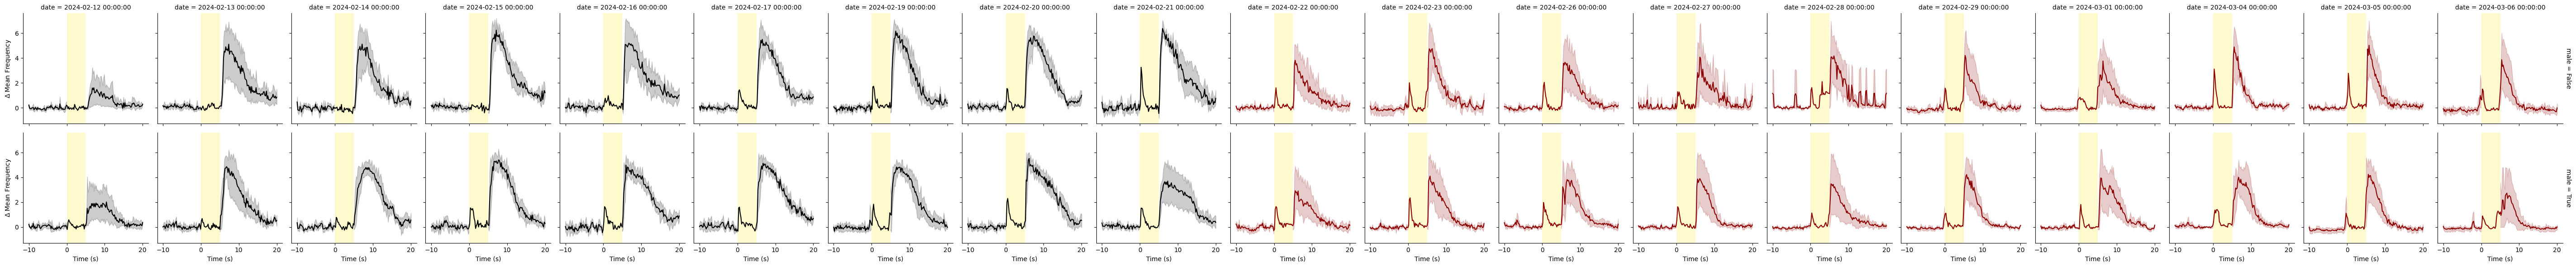

In [36]:
every_other_day = baseline_corrected_df['date'].unique()[2::2]

facet = sns.FacetGrid(baseline_corrected_df
                      .filter(pl.col('date')>filter_date), 
                      col='date',
                      row = 'male',
                      hue = 'sucralose',
                      palette=['black', 'darkred'],
                      height=3,
                      aspect=1, 
                      margin_titles=True)
facet.map(sns.lineplot, 'time',
          'lick_aligned_to_cue_baseline_corrected')
for ax in facet.axes.flat:
    draw_cue_box(ax, color='lemonchiffon', alpha=1)
    ax.set_ylabel(r'$\Delta$ Mean Frequency')
    ax.set_xlabel('Time (s)')


### mean anticipatory licks

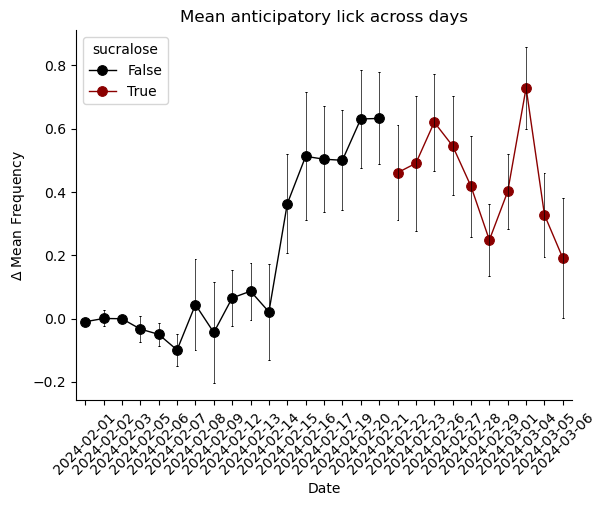

In [47]:
grouped_baseline_al =(
    baseline_corrected_df
             .filter(
                 (pl.col('time') >0) 
                 & 
                 (pl.col('time') <3)
                #  & 
                #  (pl.col('date').is_in(every_other_day))
                )
             .group_by(['subject', 'date', 'sucralose'])
             .agg([
                 pl.col('lick_aligned_to_cue_baseline_corrected').mean().alias(
                     'mean_cue_lick'),
                 pl.col('lick_aligned_to_cue_baseline_corrected').max().alias(
                     'max_cue_lick')
             ])
             .sort('date')
             .with_columns(
                 (pl.col('subject').cast(pl.Int64))
             )
             
)
def plot_anticipatory_licks(col, title):
    
    sns.pointplot(data = grouped_baseline_al,
                x = 'date',
                y=col,
                hue = 'sucralose',
                palette=['black', 'darkred'],
                errorbar='se', 
                linewidth=1, 
                color = 'black',
                markersize = 7,
                capsize=0.1,
                err_kws = {"color":'black', 
                            "linewidth": .5},
                
                )

    plt.xticks(rotation=45)
    plt.ylabel(r'$\Delta$ Mean Frequency')
    plt.xlabel('Date')
    plt.title(title)
    sns.despine()
    plt.show()
plot_anticipatory_licks('mean_cue_lick', 'Mean anticipatory lick across days')


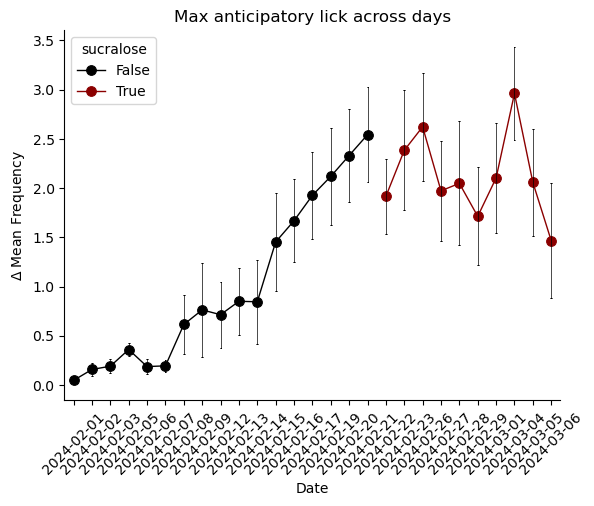

In [48]:
plot_anticipatory_licks('max_cue_lick', 'Max anticipatory lick across days')

#### read fp data and calculate group average

In [39]:
#processing is dropping males coloumns
fp_df = pl.read_parquet(fp_path).drop(
    "__index_level_0__").sort('date').sort('subject')
grouped_fp = (fp_df
              .drop('time', 'trial', 'user')
              .group_by(*[c for c in fp_df.columns if c not in ['z_score', 'time', 'trial', 'user']])
              .mean()
              .with_columns(pl.col('date').cast(pl.Date))
              )

# Cue Response

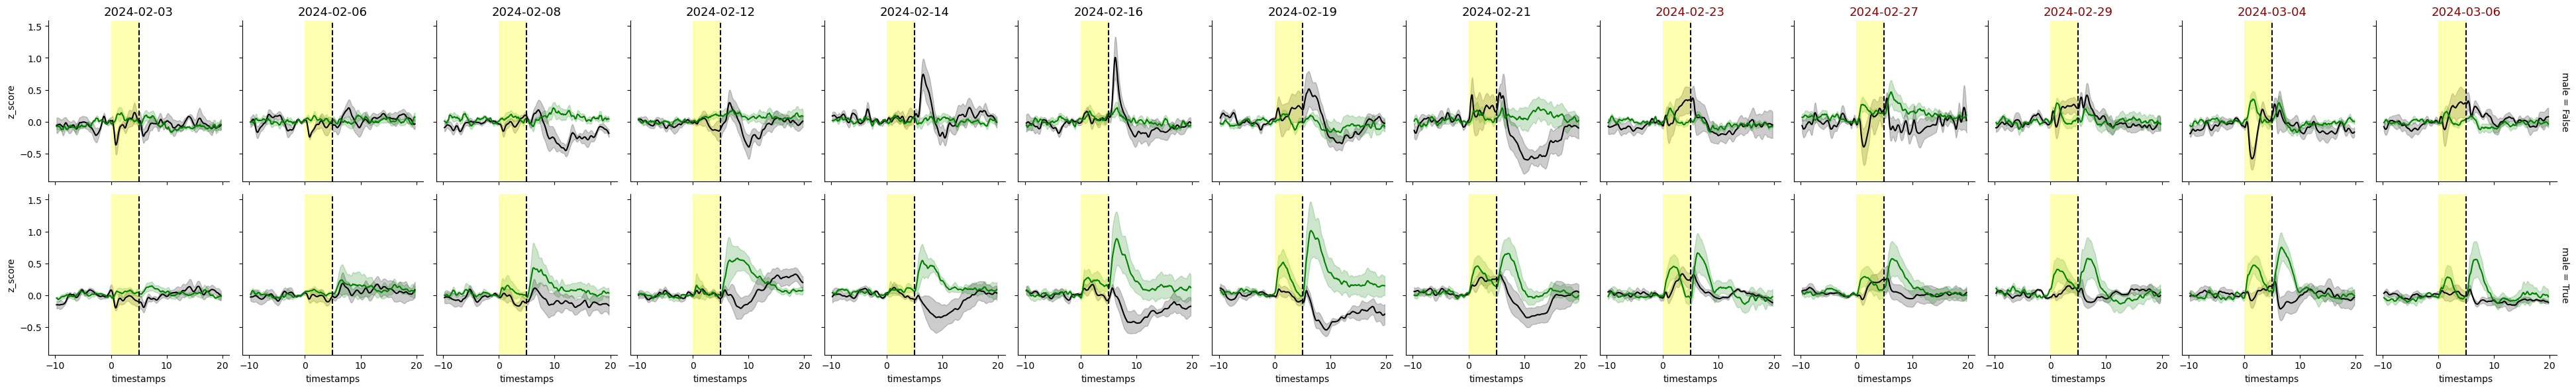

In [13]:



def plot_fp_response(event):
    sucralose_start = datetime.datetime.strptime(
        configs.config_data['reward_dates']['sucralose'], '%m-%d-%Y').date()
    
    filtered_data = (grouped_fp
                     .filter(
                         (pl.col('behavioral_events') == event)
                         & 
                         (pl.col('date').is_in(every_other_day))
                         )
                     )

                        
    facet = sns.FacetGrid(filtered_data, 
                          row = 'male',
                          col='date',
                          hue = 'structures',
                          hue_order=['NAC', 'LHA'],
                          palette=['black','green'],
                          height=3,
                          aspect=1,
                          margin_titles=True)
    facet.map(sns.lineplot, 'timestamps', 'z_score', errorbar='se')
    for ax in facet.axes.flat:
        ax.axvline(5, color='black', linestyle='--')
        draw_cue_box(ax, color='yellow', alpha=0.3)
        
    for ax in facet.axes.flat:
        label = ax.title.get_text()
        string_date = label.replace('date = ', '').replace(" 00:00:00", '')
        if len(string_date)<1:
            pass
        else:
            date = datetime.datetime.strptime(string_date,"%Y-%m-%d").date()
            if date < sucralose_start:
                ax.set_title(string_date)
                ax.title.set_color('black')
                ax.title.set_fontsize(13)
            else:
                ax.title.set_color('darkred')
                ax.set_title(string_date)
                ax.title.set_fontsize(13)
            
    plt.tight_layout()
plot_fp_response('cue')
    # return label

# Reward Response

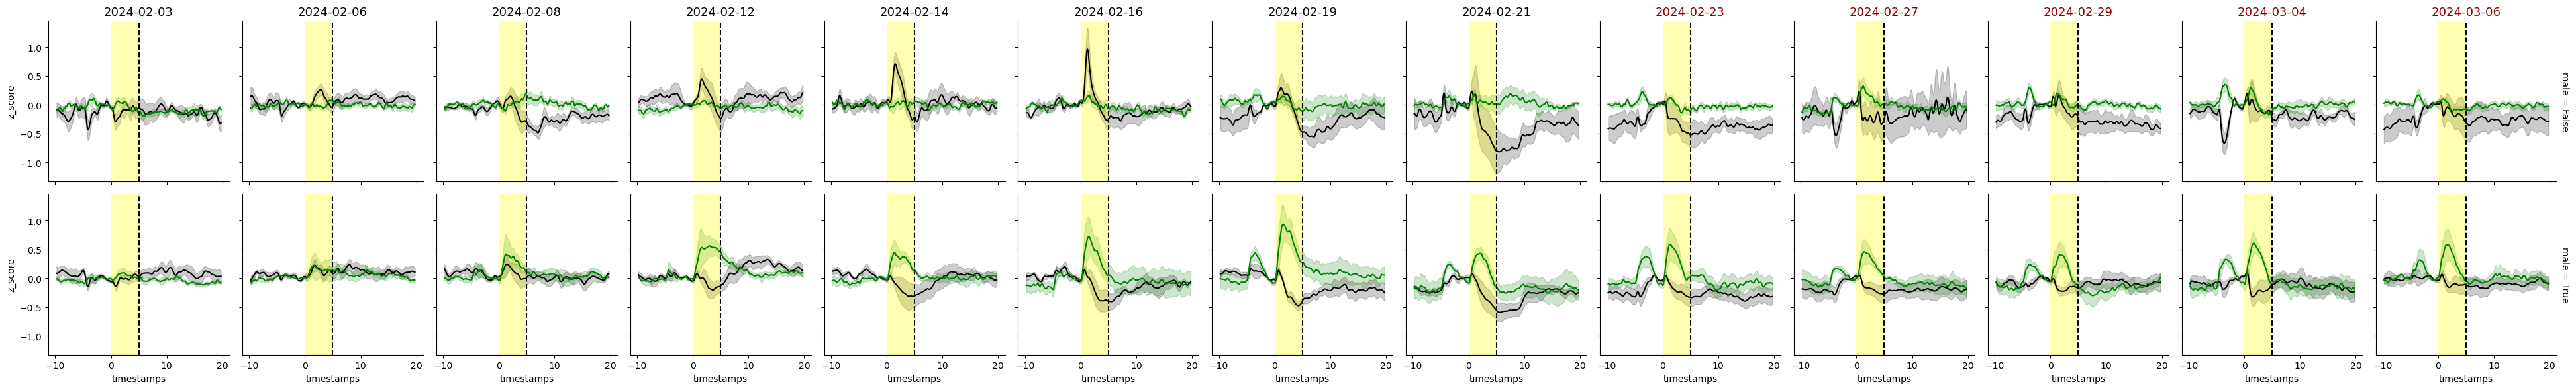

In [14]:
plot_fp_response('reward')

LHA cue response over days with anticipatory licks

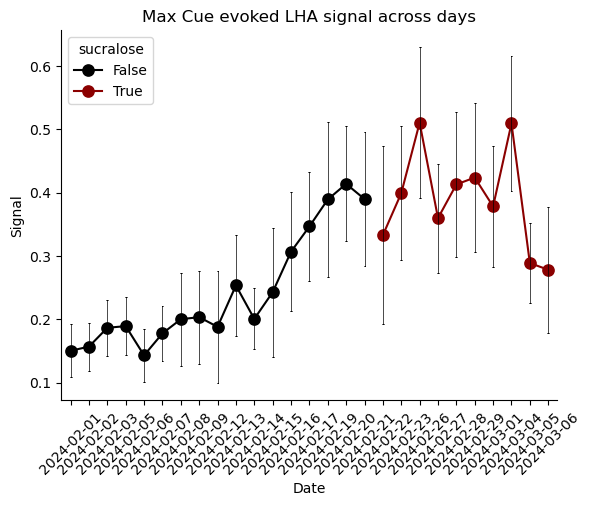

In [40]:

fp_anticipatory = (
    grouped_fp
    .rename({'z_score': 'signal'})
    .filter(
        (pl.col('timestamps') > 0)
        &
        (pl.col('timestamps') < 5)
        # & 
        # (pl.col('date').is_in(every_other_day)) = 
    )
    .group_by(['subject', 'date', 'structures', 'behavioral_events', 'male', 'sucralose'])
    .agg([
        pl.col('signal').max().alias('max_signal'),
        pl.col('signal').mean().alias('mean_signal'),
        pl.col('signal').min().alias('min_signal'),
        pl.col('signal').sum().alias('sum_signal'),
    ])
    .sort('date')
)

def plot_consolidated_fp(y_col):
    sns.pointplot(data=fp_anticipatory.to_pandas().query(
        "structures =='LHA' & behavioral_events == 'cue'"),
                x='date', 
                y=y_col,
                errorbar='se', 
                linewidth=1.5, 
                palette=['black', 'darkred'],
                hue = 'sucralose',
                #   color = 'black',
                capsize=0.1,
                err_kws = {"color":'black', 
                            "linewidth": .5},
                **{
                    'marker': 'o',
                    'markersize': 8, 
                }
                )
    plt.xticks(rotation=45)
    plt.ylabel('Signal')
    plt.xlabel('Date')
    if y_col == 'max_signal':
        plt.title(f'Max Cue evoked LHA signal across days')
    if y_col == 'mean_signal':
        plt.title(f'Mean Cue evoked LHA signal across days')
    sns.despine()
    plt.show()


plot_consolidated_fp('max_signal')

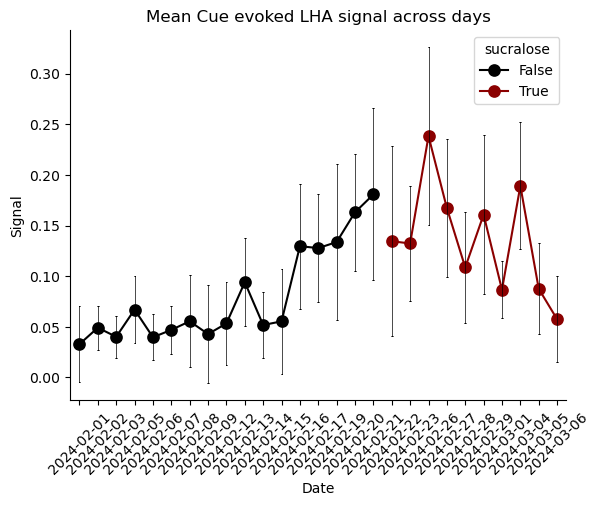

In [41]:
plot_consolidated_fp('mean_signal')

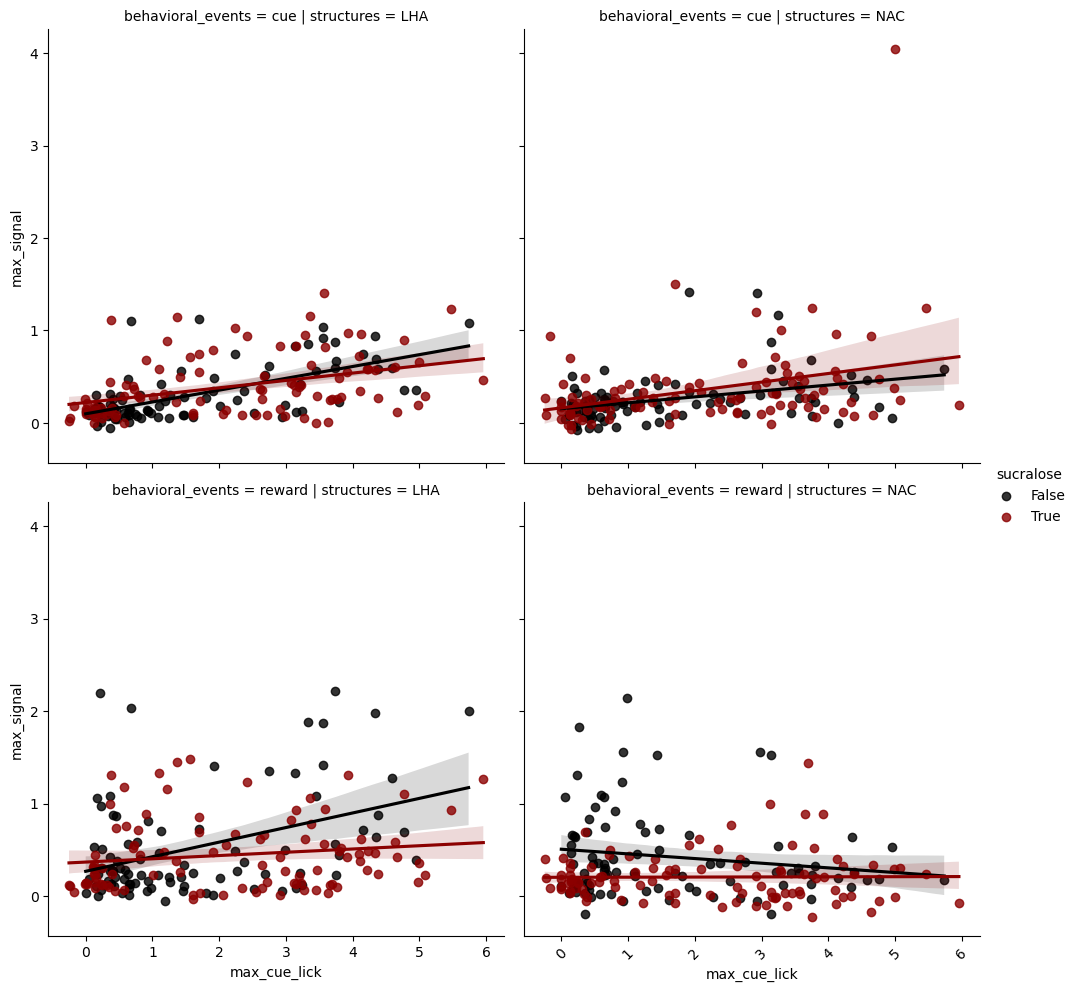

In [42]:


combined_anticipatory_data = (fp_anticipatory
                 .join(grouped_baseline_al, on = ['subject', 'date']).sort('date')
                #  .filter(pl.col('date')>filter_date)
                )

sns.lmplot(data=combined_anticipatory_data.filter(pl.col('date')>filter_date),
           x='max_cue_lick',
            y = 'max_signal', 
            col = 'structures',
            col_order = ['LHA', 'NAC'],
            row = 'behavioral_events',
            row_order = ['cue', 'reward'],
            hue = 'sucralose',
            palette=['black', 'darkred'], 
            facet_kws = {
                'sharex':True, 
                'sharey':True    
            }
            
            )
plt.xticks(rotation=45)
sns.despine()

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_4301/4246282090.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.trapz(x['z_score'], x['timestamps'])).rename({None: 'auc'}, axis=1)


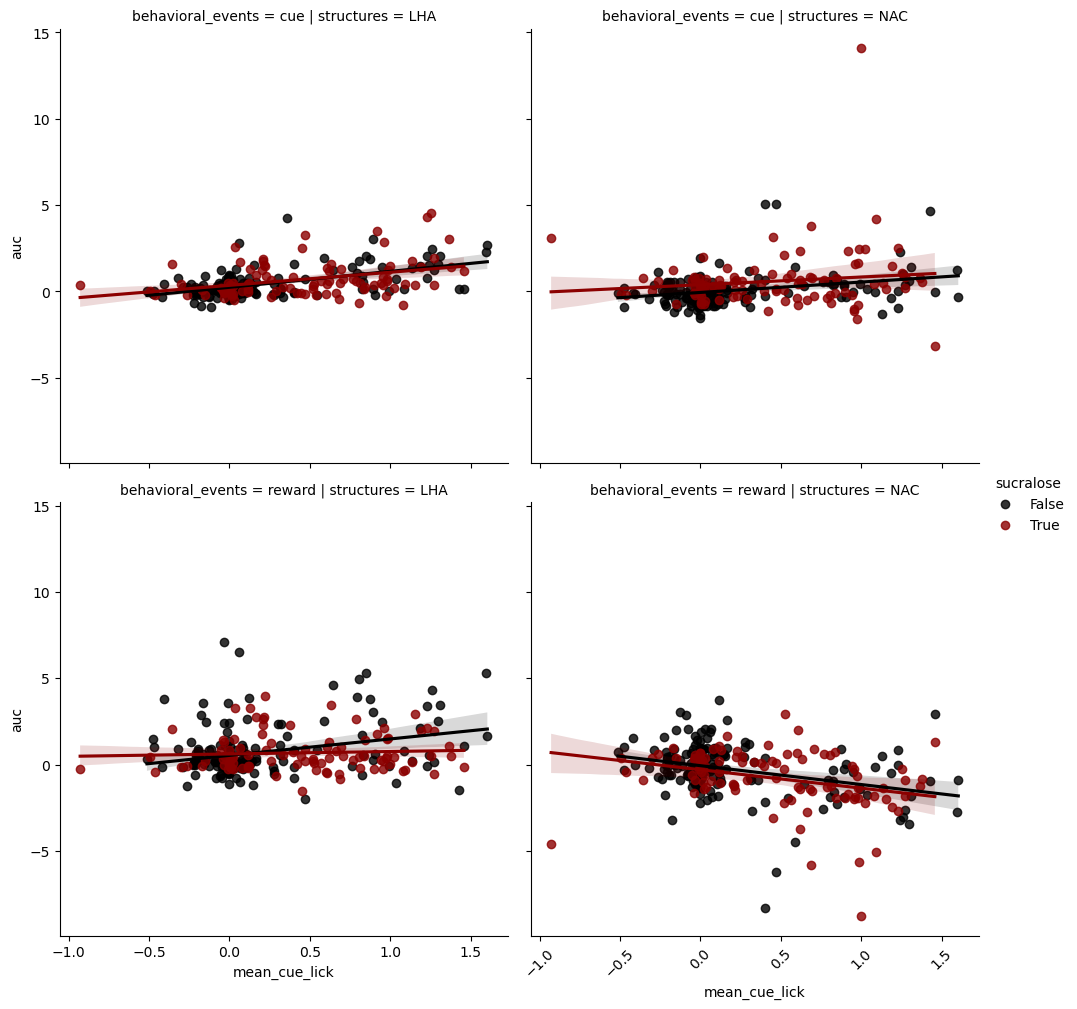

In [43]:
auc = (
    pl.from_pandas(
    grouped_fp
    .filter(
        (pl.col('timestamps') > 0)
        &
        (pl.col('timestamps') < 5)
    )
    .drop('time', 'trial', 'user')
    .sort(['subject', 'behavioral_events', 'structures', 'timestamps', 'date'])
    .to_pandas()
    .groupby(by=['behavioral_events', 'structures', 'subject', 'date'], as_index=False, observed=False)
    .apply(lambda x: np.trapz(x['z_score'], x['timestamps'])).rename({None: 'auc'}, axis=1)
    )
    .with_columns(
        (pl.col('date').cast(pl.Date))
        )
                  
)

final_data = combined_anticipatory_data.join(
    auc, on=['subject', 'date', 'structures', 'behavioral_events']).sort('date')


sns.lmplot(data=final_data,
           x='mean_cue_lick',
           y='auc',
           col='structures',
           col_order=['LHA', 'NAC'],
           row='behavioral_events',
           row_order=['cue', 'reward'],
           hue='sucralose',
           palette=['black', 'darkred'],
           facet_kws={
               'sharex': True,
               'sharey': True
           }

           )
plt.xticks(rotation=45)
sns.despine()

<Axes: xlabel='date', ylabel='auc'>

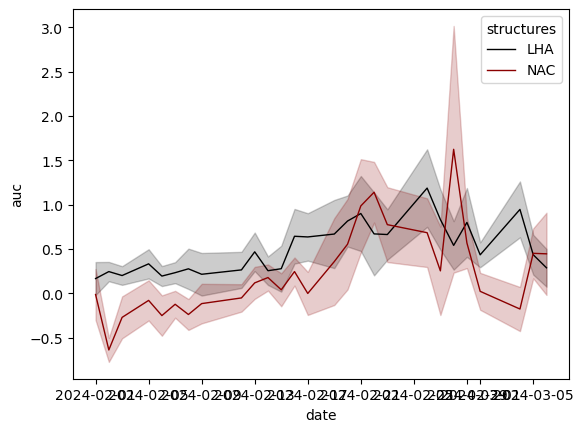

In [44]:
sns.lineplot(final_data.filter(pl.col('behavioral_events')=="cue"), 
             x = 'date', 
             y = 'auc',
             hue = 'structures',
             palette=['black', 'darkred'],
             linewidth = 1,
             errorbar='se'
             )